In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
0.将 预测结果保持小数形式，而不是转换成整数形式  结果从0.5以上优化到0.5以下 0.47381812389478345
1.将 survey_time数据提取出月份、日期、小时三个特征 0.47143198583365375
2.将 family_income，income离散成5段的离散值 0.4730428161760329
3.将 birth 转换成年龄值age 0.47143198583365375
4.将 family_income，income离散成5段的离散值，并且birth 转换成年龄值age，都加上，0.47241532744595904
6.将 age 离散化成7段年龄段  0.47619062169156706
7.将 survey_time数据提取出一周的第几天、是否周末 两个特征 0.47097871771026456
8.将 family_income、income中小于0的数字转换为0 0.4708401593321734
9.使用全量特征训练 0.466104881012437
10.将 family_income，income提取出来家庭收入占个人收入的比例特征，0.46458776964941884
11.调参：
    1.将max_depth由6调整为8，0.46458776964941884-》0.4623970704927228
    2.将n_estimators由100调整为200  0.4623970704927228-》0.462396775672775
    3.将min_child_weight由1-》2-》3  0.462396775672775-》0.4616176256431441-》0.46051453956155897
    4.将subsample由1调整为0.6  0.46051453956155897-》0.4552454001761164
    5.将colsample_bytree由1调整为0.6  0.4552454001761164->0.4520618951047676
12.将所有的训练样本全部用作训练集，不再分出一部分作为验证机集，以期在测试集上能取得更好的效果
13.将 survey_time数据提取出季度、年份特征 0.4520618951047676-》0.45104197365888876
"""

import xgboost as xgb
import numpy as np
import pandas as pd
import tensorflow as tf
from datetime import datetime
from sklearn.model_selection import KFold
#显示所有列
pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', None)


In [2]:
data_dir = '/Users/changqingli/pycharm_projects/algorithms/weekend_content/'
train_data_file = 'data/happiness_train_complete.csv'
test_data_file = 'data/happiness_test_complete.csv'


In [3]:
df_train = pd.read_csv(data_dir+train_data_file, encoding='gb2312')
df_test = pd.read_csv(data_dir+test_data_file, encoding='gb2312')
df_train.head()

,id,happiness,survey_type,province,city,county,survey_time,gender,birth,nationality,religion,religion_freq,edu,edu_other,edu_status,edu_yr,income,political,join_party,floor_area,property_0,property_1,property_2,property_3,property_4,property_5,property_6,property_7,property_8,property_other,height_cm,weight_jin,health,health_problem,depression,hukou,hukou_loc,media_1,media_2,media_3,media_4,media_5,media_6,leisure_1,leisure_2,leisure_3,leisure_4,leisure_5,leisure_6,leisure_7,leisure_8,leisure_9,leisure_10,leisure_11,leisure_12,socialize,relax,learn,social_neighbor,social_friend,socia_outing,equity,class,class_10_before,class_10_after,class_14,work_exper,work_status,work_yr,work_type,work_manage,insur_1,insur_2,insur_3,insur_4,family_income,family_m,family_status,house,car,invest_0,invest_1,invest_2,invest_3,invest_4,invest_5,invest_6,invest_7,invest_8,invest_other,son,daughter,minor_child,marital,marital_1st,s_birth,marital_now,s_edu,s_political,s_hukou,s_income,s_work_exper,s_work_status,s_work_type,f_birth,f_edu,f_political,f_work_14,m_birth,m_edu,m_political,m_work_14,status_peer,status_3_before,view,inc_ability,inc_exp,trust_1,trust_2,trust_3,trust_4,trust_5,trust_6,trust_7,trust_8,trust_9,trust_10,trust_11,trust_12,trust_13,neighbor_familiarity,public_service_1,public_service_2,public_service_3,public_service_4,public_service_5,public_service_6,public_service_7,public_service_8,public_service_9
0,1,4,1,12,32,59,2015/8/4 14:18,1,1959,1,1,1,11,NaN,4.0,-2.0,20000,1,NaN,45.0,0,1,0,0,0,0,0,0,0,NaN,176,155,3,2,5,5,2.0,4,2,5,5,4,3,1,4,3,1,2,3,4,1,4,5,4,1,2,4,3,3.0,3.0,2,3,3,3,3,1,1,3.0,30.0,1.0,2.0,1,1,1,2,60000.0,2,2,1,2,0,1,0,0,0,0,0,0,0,NaN,1,0,0.0,3,1984.0,1958.0,1984.0,6.0,1.0,5.0,40000.0,5.0,NaN,NaN,-2,4,4,1,-2,4,1,1,3,2,4,3,50000.0,4,2,-8,-8,5,3,2,3,4,3,-8,4,1,4,50,60,50,50,30.0,30,50,50,50
1,2,4,2,18,52,85,2015/7/21 15:04,1,1992,1,1,1,12,NaN,4.0,2013.0,20000,1,NaN,110.0,0,0,0,0,1,0,0,0,0,NaN,170,110,5,4,3,1,1.0,2,2,1,3,5,1,2,3,4,3,5,4,3,2,3,4,5,1,2,4,3,6.0,2.0,1,3,6,4,8,5,1,3.0,2.0,1.0,3.0,1,1,1,1,40000.0,3,4,1,2,0,1,0,0,0,0,0,0,0,NaN,0,0,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1972,3,1,2,1973,3,1,2,1,1,4,2,50000.0,5,4,4,3,5,3,3,3,2,3,3,3,2,3,90,70,70,80,85.0,70,90,60,60
2,3,4,2,29,83,126,2015/7/21 13:24,2,1967,1,0,3,4,NaN,4.0,-2.0,2000,1,NaN,120.0,0,1,1,0,0,0,0,0,0,NaN,160,122,4,4,5,1,1.0,2,2,2,5,1,3,1,4,4,3,5,4,4,2,3,5,5,5,3,4,2,2.0,5.0,2,4,5,4,6,3,2,NaN,NaN,NaN,NaN,1,1,2,2,8000.0,3,3,1,2,0,1,0,0,0,0,0,0,0,NaN,0,2,1.0,3,1990.0,1968.0,1990.0,3.0,1.0,1.0,6000.0,3.0,NaN,NaN,-2,1,1,2,-2,1,1,2,2,1,4,2,80000.0,3,3,3,3,4,3,3,3,3,3,-8,3,1,4,90,80,75,79,80.0,90,90,90,75
3,4,5,2,10,28,51,2015/7/25 17:33,2,1943,1,1,1,3,NaN,4.0,1959.0,6420,1,NaN,78.0,0,0,0,1,0,0,0,0,0,NaN,163,170,4,4,4,1,2.0,2,1,1,5,1,1,1,5,2,4,5,4,5,1,1,5,5,5,2,4,4,1.0,6.0,1,4,5,5,7,2,4,NaN,NaN,NaN,NaN,2,2,2,2,12000.0,3,3,1,1,0,1,0,0,0,0,0,0,0,NaN,1,4,0.0,7,1960.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2,14,1,2,-2,1,1,2,2,1,3,2,10000.0,3,3,4,3,5,3,3,5,4,3,3,3,2,3,100,90,70,80,80.0,90,90,80,80
4,5,4,1,7,18,36,2015/8/10 9:50,2,1994,1,1,1,12,NaN,1.0,2014.0,-1,2,NaN,70.0,0,0,0,0,1,0,0,0,0,NaN,165,110,5,5,3,2,3.0,1,3,4,2,5,5,3,3,3,2,4,4,3,5,2,5,5,1,4,3,4,7.0,5.0,3,2,1,1,1,4,6,NaN,NaN,NaN,NaN,1,2,2,2,-2.0,4,3,1,1,0,1,0,0,0,0,0,0,0,NaN,0,0,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1970,6,1,10,1972,4,1,15,3,2,3,-8,200000.0,4,3,3,3,5,5,3,4,3,3,3,3,2,2,50,50,50,50,50.0,50,50,50,50


In [4]:
df_train.isnull().sum()

id                         0
happiness                  0
survey_type                0
province                   0
city                       0
county                     0
survey_time                0
gender                     0
birth                      0
nationality                0
religion                   0
religion_freq              0
edu                        0
edu_other               7997
edu_status              1120
edu_yr                  1972
income                     0
political                  0
join_party              7176
floor_area                 0
property_0                 0
property_1                 0
property_2                 0
property_3                 0
property_4                 0
property_5                 0
property_6                 0
property_7                 0
property_8                 0
property_other          7934
height_cm                  0
weight_jin                 0
health                     0
health_problem             0
depression    

In [5]:
df_train = df_train.drop('id', 1)
df_train = df_train[df_train['happiness'] != -8]
df_train = df_train[pd.to_datetime(df_train.survey_time).dt.month != 2]


In [6]:
# survey_time数据提取出月份、日期、小时三个特征
df_train['year'] = pd.to_datetime(df_train.survey_time).dt.year
df_train['quarter'] = pd.to_datetime(df_train.survey_time).dt.quarter
df_train['month'] = pd.to_datetime(df_train.survey_time).dt.month
df_train['day'] = pd.to_datetime(df_train.survey_time).dt.day
df_train['hour'] = pd.to_datetime(df_train.survey_time).dt.hour
df_train['dayofweek'] = pd.to_datetime(df_train.survey_time).dt.dayofweek+1
df_train['is_weekend'] = (pd.to_datetime(df_train.survey_time).dt.dayofweek+1).apply(lambda x: 1 if x in (6, 7) else 0)
df_test['year'] = pd.to_datetime(df_test.survey_time).dt.year
df_test['quarter'] = pd.to_datetime(df_test.survey_time).dt.quarter
df_test['month'] = pd.to_datetime(df_test.survey_time).dt.month
df_test['day'] = pd.to_datetime(df_test.survey_time).dt.day
df_test['hour'] = pd.to_datetime(df_test.survey_time).dt.hour
df_test['dayofweek'] = pd.to_datetime(df_test.survey_time).dt.dayofweek+1
df_test['is_weekend'] = (pd.to_datetime(df_test.survey_time).dt.dayofweek+1).apply(lambda x: 1 if x in (6, 7) else 0)
# 去除 survey_time数据
df_train = df_train.drop('survey_time', 1)
df_test = df_test.drop('survey_time', 1)
# 是否是共产党员
# df_train['join_party'] = 
# 家庭收入是个人收入的比例
df_train['income_rate'] = df_train.apply(lambda row: row['family_income']/row['income'] if row['family_income']*row['income']>0 else 0, 1)
df_test['income_rate'] = df_test.apply(lambda row: row['family_income']/row['income'] if row['family_income']*row['income']>0 else 0, 1)
# 将family_income、income小于0的值转换为0值
df_train['family_income'] = df_train['family_income'].apply(lambda x: x if x>0 else 0)
df_train['income'] = df_train['income'].apply(lambda x: x if x>0 else 0)
df_test['family_income'] = df_test['family_income'].apply(lambda x: x if x>0 else 0)
df_test['income'] = df_test['income'].apply(lambda x: x if x>0 else 0)
# family_income，income离散成5段的离散值
family_income_quantile = df_train.family_income.quantile([0, 0.2, 0.4, 0.6, 0.8, 1]).values
df_train['family_income_stage'] = pd.cut(df_train.family_income, family_income_quantile, labels=[0, 1, 2, 3, 4])
income_quantile = df_train.income.quantile([0, 0.33, 0.66, 1]).values
df_train['income_stage'] = pd.cut(df_train.income, income_quantile, labels=[0, 1, 2])
family_income_quantile = df_test.family_income.quantile([0, 0.2, 0.4, 0.6, 0.8, 1]).values
df_test['family_income_stage'] = pd.cut(df_test.family_income, family_income_quantile, labels=[0, 1, 2, 3, 4])
income_quantile = df_test.income.quantile([0, 0.33, 0.66, 1]).values
df_test['income_stage'] = pd.cut(df_test.income, income_quantile, labels=[0, 1, 2])
# birth 转换成年龄值
df_train['age']  = df_train['year'] - df_train['birth']
df_train = df_train.drop('birth', 1)
# df_train['age'] = pd.cut(df_train.age, [0, 20, 30, 40, 50, 60, 70, 100], labels=[0, 1, 2, 3, 4, 5, 6])
df_test['age']  = df_test['year'] - df_test['birth']
df_test = df_test.drop('birth', 1)
# df_test['age'] = pd.cut(df_test.age, [0, 20, 30, 40, 50, 60, 70, 100], labels=[0, 1, 2, 3, 4, 5, 6])

#收入分组
def income_cut(x):
    if x<0:
        return 0
    elif  0<=x<1200:
        return 1
    elif  1200<x<=10000:
        return 2
    elif  10000<x<24000:
        return 3
    elif  24000<x<40000:
        return 4
    elif  40000<=x:
        return 5
    
# df_train["income_cut"]=df_train["income"].map(income_cut)
# df_test["income_cut"]=df_test["income"].map(income_cut)


df_train.head()


,happiness,survey_type,province,city,county,gender,nationality,religion,religion_freq,edu,edu_other,edu_status,edu_yr,income,political,join_party,floor_area,property_0,property_1,property_2,property_3,property_4,property_5,property_6,property_7,property_8,property_other,height_cm,weight_jin,health,health_problem,depression,hukou,hukou_loc,media_1,media_2,media_3,media_4,media_5,media_6,leisure_1,leisure_2,leisure_3,leisure_4,leisure_5,leisure_6,leisure_7,leisure_8,leisure_9,leisure_10,leisure_11,leisure_12,socialize,relax,learn,social_neighbor,social_friend,socia_outing,equity,class,class_10_before,class_10_after,class_14,work_exper,work_status,work_yr,work_type,work_manage,insur_1,insur_2,insur_3,insur_4,family_income,family_m,family_status,house,car,invest_0,invest_1,invest_2,invest_3,invest_4,invest_5,invest_6,invest_7,invest_8,invest_other,son,daughter,minor_child,marital,marital_1st,s_birth,marital_now,s_edu,s_political,s_hukou,s_income,s_work_exper,s_work_status,s_work_type,f_birth,f_edu,f_political,f_work_14,m_birth,m_edu,m_political,m_work_14,status_peer,status_3_before,view,inc_ability,inc_exp,trust_1,trust_2,trust_3,trust_4,trust_5,trust_6,trust_7,trust_8,trust_9,trust_10,trust_11,trust_12,trust_13,neighbor_familiarity,public_service_1,public_service_2,public_service_3,public_service_4,public_service_5,public_service_6,public_service_7,public_service_8,public_service_9,year,quarter,month,day,hour,dayofweek,is_weekend,income_rate,family_income_stage,income_stage,age
0,4,1,12,32,59,1,1,1,1,11,NaN,4.0,-2.0,20000,1,NaN,45.0,0,1,0,0,0,0,0,0,0,NaN,176,155,3,2,5,5,2.0,4,2,5,5,4,3,1,4,3,1,2,3,4,1,4,5,4,1,2,4,3,3.0,3.0,2,3,3,3,3,1,1,3.0,30.0,1.0,2.0,1,1,1,2,60000.0,2,2,1,2,0,1,0,0,0,0,0,0,0,NaN,1,0,0.0,3,1984.0,1958.0,1984.0,6.0,1.0,5.0,40000.0,5.0,NaN,NaN,-2,4,4,1,-2,4,1,1,3,2,4,3,50000.0,4,2,-8,-8,5,3,2,3,4,3,-8,4,1,4,50,60,50,50,30.0,30,50,50,50,2015,3,8,4,14,2,0,3.000000,3,1,56
1,4,2,18,52,85,1,1,1,1,12,NaN,4.0,2013.0,20000,1,NaN,110.0,0,0,0,0,1,0,0,0,0,NaN,170,110,5,4,3,1,1.0,2,2,1,3,5,1,2,3,4,3,5,4,3,2,3,4,5,1,2,4,3,6.0,2.0,1,3,6,4,8,5,1,3.0,2.0,1.0,3.0,1,1,1,1,40000.0,3,4,1,2,0,1,0,0,0,0,0,0,0,NaN,0,0,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1972,3,1,2,1973,3,1,2,1,1,4,2,50000.0,5,4,4,3,5,3,3,3,2,3,3,3,2,3,90,70,70,80,85.0,70,90,60,60,2015,3,7,21,15,2,0,2.000000,2,1,23
2,4,2,29,83,126,2,1,0,3,4,NaN,4.0,-2.0,2000,1,NaN,120.0,0,1,1,0,0,0,0,0,0,NaN,160,122,4,4,5,1,1.0,2,2,2,5,1,3,1,4,4,3,5,4,4,2,3,5,5,5,3,4,2,2.0,5.0,2,4,5,4,6,3,2,NaN,NaN,NaN,NaN,1,1,2,2,8000.0,3,3,1,2,0,1,0,0,0,0,0,0,0,NaN,0,2,1.0,3,1990.0,1968.0,1990.0,3.0,1.0,1.0,6000.0,3.0,NaN,NaN,-2,1,1,2,-2,1,1,2,2,1,4,2,80000.0,3,3,3,3,4,3,3,3,3,3,-8,3,1,4,90,80,75,79,80.0,90,90,90,75,2015,3,7,21,13,2,0,4.000000,0,0,48
3,5,2,10,28,51,2,1,1,1,3,NaN,4.0,1959.0,6420,1,NaN,78.0,0,0,0,1,0,0,0,0,0,NaN,163,170,4,4,4,1,2.0,2,1,1,5,1,1,1,5,2,4,5,4,5,1,1,5,5,5,2,4,4,1.0,6.0,1,4,5,5,7,2,4,NaN,NaN,NaN,NaN,2,2,2,2,12000.0,3,3,1,1,0,1,0,0,0,0,0,0,0,NaN,1,4,0.0,7,1960.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2,14,1,2,-2,1,1,2,2,1,3,2,10000.0,3,3,4,3,5,3,3,5,4,3,3,3,2,3,100,90,70,80,80.0,90,90,80,80,2015,3,7,25,17,6,1,1.869159,1,1,72
4,4,1,7,18,36,2,1,1,1,12,NaN,1.0,2014.0,0,2,NaN,70.0,0,0,0,0,1,0,0,0,0,NaN,165,110,5,5,3,2,3.0,1,3,4,2,5,5,3,3,3,2,4,4,3,5,2,5,5,1,4,3,4,7.0,5.0,3,2,1,1,1,4,6,NaN,NaN,NaN,NaN,1,2,2,2,0.0,4,3,1,1,0,1,0,0,0,0,0,0,0,NaN,0,0,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1970,6,1,10,1972,4,1,15,3,2,3,-8,200000.0,4,3,3,3,5,5,3,4,3,3,3,3,2,2,50,50,50,50,50.0,50,50,50,50,2015,3,8,10,9,1,0,2.000000,NaN,NaN,21


In [7]:
# df_train.loc[1, :]

In [8]:
df_train = df_train.drop('property_other', 1).drop('edu_other', 1).drop('invest_other', 1)
df_test = df_test.drop('property_other', 1).drop('edu_other', 1).drop('invest_other', 1)

In [9]:
# df_train.loc[1, :]
# df_train['property_other'].value_counts()
# df_train.loc[1, :]

In [10]:
# df_train.floor_area.value_counts()

In [11]:
len(df_train)
len(df_test)

2968

In [12]:
df_train = df_train.fillna(0)
df_test = df_test.fillna(0)
df_train_train = df_train
df_train_train = df_train.sample(frac=0.8, random_state=0, axis=0)
df_train_validation = df_train[~df_train.index.isin(df_train_train.index)]


In [13]:
# len(df_train_validation)

In [14]:
tr_data = df_train_train.as_matrix()
va_data = df_train_validation.as_matrix()
te_data = df_test.as_matrix()
tr_data

/Users/changqingli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/Users/changqingli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/Users/changqingli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


array([[3, 1, 1, ..., 1, 0, 19],
       [4, 1, 12, ..., 2, 2, 20],
       [5, 1, 21, ..., 2, 2, 35],
       ...,
       [3, 2, 29, ..., 0, 0, 61],
       [5, 1, 1, ..., 0, 0, 43],
       [4, 2, 18, ..., 4, 0, 26]], dtype=object)

In [15]:
tr_x_data = tr_data[:, 1:]
tr_y_data = tr_data[:, 0]

va_x_data = va_data[:, 1:]
va_y_data = va_data[:, 0]

In [16]:
len(tr_x_data[0])
# df_train.edu_other.value_counts()

144

In [17]:
# (tr_x_data.index('统筹'))
# for i in range(len(tr_x_data)):
#     for j in range(len(tr_x_data[i])):
#         if tr_x_data[i][j] == '统筹':
#             print(i, j)

# list(df_train.columns)[84]


In [18]:
mod = xgb.XGBRegressor(max_depth=8,
                       learning_rate=0.1,
                       n_estimators=200,
                       objective='reg:linear',
                       booster='gbtree',
                       gamma=5,
                       reg_lambda=10,
                       min_child_weight=3,
                       subsample=0.6,
                       colsample_bytree=0.6)

In [19]:
mod.fit(tr_x_data, tr_y_data)

[23:08:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=5,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=8, min_child_weight=3, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=10, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.6, verbosity=1)

In [20]:
va_pred_data = mod.predict(va_x_data)
np.mean((va_pred_data - va_y_data)*(va_pred_data - va_y_data))

0.45104197365888876

In [21]:
pred_data = te_data[:, 1:]
pred_res = mod.predict(pred_data)

import csv
result = 'submission_908_xgb_tiaocan_6.csv'
with open(data_dir+result, 'w') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['id', 'happiness'])
    for i in range(len(te_data)):
        writer.writerow([int(te_data[i][0]), pred_res[i]])

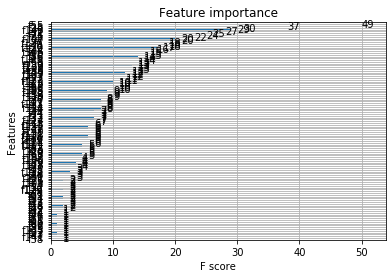

In [22]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline
plot_importance(mod)
plt.show()
# list(mod.feature_importances_)
# len(list(df_train_train.columns)[1:])